In [2]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import scipy.stats
import statsmodels
import statsmodels.sandbox.stats.multicomp
import pandas as pd
from sklearn.utils import shuffle
import hashlib
import warnings
warnings.filterwarnings("ignore")

In [3]:
def time_split(df, date_end, date_valid):
    df_avg_all_sample = df[df.day < date_end]
    df_avg_all_train = df_avg_all_sample[(df_avg_all_sample.day < date_valid)]
    df_avg_all_valid = df_avg_all_sample[(df_avg_all_sample.day >= date_valid)]
    return df_avg_all_train, df_avg_all_valid, df_avg_all_sample

def get_boundary(dist, alpha=0.05):
    return np.percentile(dist, [100 * alpha / 2., 100 * (1 - alpha / 2.)])


def bootstrap(group_A, group_B, alpha=0.05, iters=100, return_distribution=False):
    dist = []
    for i in range(iters):
        dist.append(
            np.random.choice(group_A, replace=True, size=len(group_A)).mean()
            -
            np.random.choice(group_B, replace=True, size=len(group_B)).mean()
        )
        
    if return_distribution:
        return dist
    return get_boundary(dist, alpha)

def combination_test(data_fst, data_snd, iters=1000, plot=True):
    data = np.array(list(data_fst) + list(data_snd))
    size = len(data)
    values = []
    fst_ratio = len(data_fst) * 1. / size
    for _ in range(iters):
        mask = (np.random.random(size=size) < fst_ratio)
        values.append(data[mask].mean() - data[~mask].mean())
        
    if plot:
        plt.hist(values, bins=30)
        plt.show()
        
    return (np.abs(values) > np.abs(data_fst.mean() - data_snd.mean())).mean()

def get_p_value(dist):
    dist = np.array(dist)
    x = (dist > 0).mean()
    pvalue = min(x, 1-x) * 2
    return pvalue

def search_df(regs_A, regs_B, group_reg = False):
    if not group_reg:
        df_train = df_avg_all_train.copy() # train данные (1 день)
        df_val = df_avg_all_valid.copy() # valid данные (2 день)
    else:
        df_train = df_all_group_train_reg.copy()
        df_val = df_all_group_valid_reg.copy()
    df_all_A_train = df_train.loc[regs_A]# train данные (1-й день покупки) по 5000 уникальным user_id 1 группы
    df_all_B_train = df_train.loc[regs_B]# train данные (1-й день покупки) по 5000 уникальным user_id 2 группы
    df_all_A_valid = df_val.loc[regs_A]# valid данные (2-й день покупки) по 5000 уникальным user_id 1 группы
    df_all_B_valid = df_val.loc[regs_B]# valid данные (2-й день покупки) по 5000 уникальным user_id 2 группы
    return df_all_A_train, df_all_B_train, df_all_A_valid, df_all_B_valid

def plot_tms(col_feature, col_date, regs_A, regs_B, name):
    df_avg_A = df_avg_all_sample.loc[regs_A].groupby(['day']).mean().reset_index()
    df_avg_B = df_avg_all_sample.loc[regs_B].groupby(['day']).mean().reset_index()
    plt.figure(figsize=(40,20))
    plt.axvline(9, 0, 1, label='pilot', c='m')
    plt.plot(df_avg_A[col_date].tolist(), df_avg_A[col_feature].tolist(), label = 'A',  linewidth=6)
    plt.plot(df_avg_B[col_date].tolist(), df_avg_B[col_feature].tolist(), label = 'B',  linewidth=6)
    plt.legend()
    plt.savefig(name)
    
def create_regs_names(A_l):
    B_l = np.setdiff1d(regs, A_l) # выбрать те user_id, которых нет A_1 (random_regs)
    regs_A = np.array(regs)[A_l]
    regs_B = np.array(regs)[B_l]
    return regs_A, regs_B # 2 рандомных массива с уникальными user_id

def random_regs(): # выбрать рандомно 5 000 user_id из 10 000
    A_l = np.random.choice(regs, size = 5000, replace = False)
    return create_regs_names(A_l)

def cuped(df_all_A_train_reg, df_all_B_train_reg, df_all_A_valid_reg, df_all_B_valid_reg):

    df_all_A = df_all_A_train_reg.merge(df_all_A_valid_reg, on = ['user_id'])
    df_all_B = df_all_B_train_reg.merge(df_all_B_valid_reg, on = ['user_id'])
    df_all_A['group'] = 'A'
    df_all_B['group'] = 'B'
    
    df_all_cuped = pd.concat([df_all_A, df_all_B], axis = 0)
    df_all_cuped = shuffle(df_all_cuped)
    
    mean_cov = df_all_cuped['metric_x'].mean()
    variance = df_all_cuped['metric_x'].var()
    cov = df_all_cuped[['metric_x','metric_y']].cov().values[0,1]
    theta = cov / variance
    df_all_cuped['cuped'] = df_all_cuped.apply(lambda x: x['metric_y'] - (x['metric_x'] - mean_cov) * theta, axis = 1)
    
    df_all_A = df_all_cuped[df_all_cuped.group == 'A']
    df_all_B = df_all_cuped[df_all_cuped.group == 'B']
    return df_all_A, df_all_B

def rank_transformation(df_all_A, df_all_B):
    df_all_A['group'] = 'A'
    df_all_B['group'] = 'B'
    df_all_ = pd.concat([df_all_A, df_all_B], axis = 0)
    df_all_ = df_all_.sort_values('cuped').reset_index().reset_index()
    df_all_['rank'] = df_all_['index'].apply(lambda x: 2/df_all_.shape[0] * x - 0.5 )
    df_all_A_, df_all_B_ = df_all_[df_all_['group'] == 'A'], df_all_[df_all_['group'] == 'B']
    return df_all_A_, df_all_B_

def rank_transformation_solo(df_all_A_train_reg, df_all_B_train_reg, df_all_A_valid_reg, df_all_B_valid_reg):
    df_all_A = df_all_A_train_reg.merge(df_all_A_valid_reg, on = ['user_id'])
    df_all_B = df_all_B_train_reg.merge(df_all_B_valid_reg, on = ['user_id'])
    df_all_A['group'] = 'A'
    df_all_B['group'] = 'B'
    df_all_ = pd.concat([df_all_A, df_all_B], axis = 0)
    df_all_ = df_all_.sort_values('cuped').reset_index().reset_index()
    df_all_['rank'] = df_all_['index'].apply(lambda x: 2/df_all_.shape[0] * x - 0.5 )
    df_all_A_, df_all_B_ = df_all_[df_all_['group'] == 'A'], df_all_[df_all_['group'] == 'B']
    return df_all_A_, df_all_B_

In [4]:
with open('Exp2.csv') as csv:
    data = pd.read_csv(csv)

In [5]:
data = data.drop(data.columns[0], 1)
data

,user_id,metric,day
0,4768,5210.050500,8
1,1928,1617.534800,8
2,2995,6742.954000,5
3,5885,8998.112105,15
4,6121,2281.206200,1
...,...,...,...
19995,4257,6853.369866,17
19996,9330,13766.185155,10
19997,317,5002.546357,17
19998,8303,1979.965400,3


In [6]:
data.groupby('user_id').agg({'metric': ['min', 'max'], 'day': ['min', 'max']})

metric               day    
               min           max min max
user_id                                 
0        1075.5862   4758.758618   0  10
1        3877.8766   7618.750465   1  11
2        5654.4472  11222.457783   2  12
3        3194.8235   7326.689164   3  13
4        2399.5957   5242.259876   4  14
...            ...           ...  ..  ..
9995     4748.3976   8905.810629   5  15
9996     1845.1253   6144.051571   6  16
9997     2526.6759   6386.189787   7  17
9998     4154.2834   6457.798268   8  18
9999     1301.9630   5873.507316   9  19

[10000 rows x 4 columns]

stat = 0.9764350056648254, pvalue = 0.0
pvalue < 0.05, отклоняем гипотезу о нормальности распределения


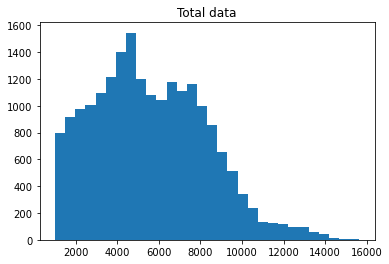

In [7]:
plt.hist(data.metric, bins = 30)
plt.title('Total data');
plt.savefig('1.png')
stat, pvalue = scipy.stats.shapiro(data.metric)
print(f'stat = {stat}, pvalue = {pvalue}')
print('pvalue < 0.05, отклоняем гипотезу о нормальности распределения');

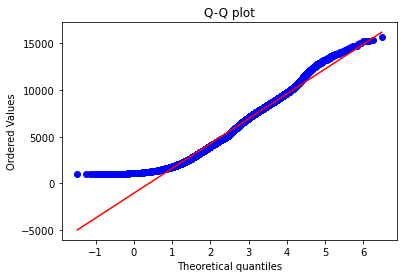

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
res = scipy.stats.probplot(data.metric, dist='norm', sparams=(2.5,), plot=ax)
ax.set_title("Q-Q plot")
plt.savefig('2.png')

mean = 3760.8690929099926, std = 1826.7990346438123
stat = 0.9362542033195496, pvalue = 0.0
pvalue < 0.05, отклоняем гипотезу о нормальности распределения


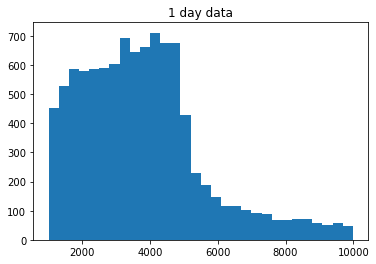

In [8]:
data_1_day = data.sort_values(['user_id', 'day']).drop_duplicates(subset=['user_id'])
print(f'mean = {data_1_day.metric.mean()}, std = {data_1_day.metric.std()}')
plt.hist(data_1_day.metric, bins = 30)
plt.title('1 day data')
stat, pvalue = scipy.stats.shapiro(data_1_day.metric)
print(f'stat = {stat}, pvalue = {pvalue}')
print('pvalue < 0.05, отклоняем гипотезу о нормальности распределения');

Text(0.5, 1.0, 'Q-Q plot')

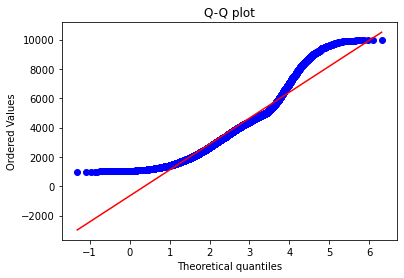

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
res = scipy.stats.probplot(data_1_day.metric, dist='norm', sparams=(2.5,), plot=ax)
ax.set_title("Q-Q plot")

mean = 7456.122470084493, std = 2088.3103648875153
stat = 0.9757167100906372, pvalue = 5.113447397601475e-38
pvalue < 0.05, отклоняем гипотезу о нормальности распределения


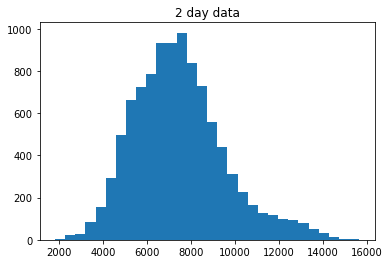

In [10]:
data_2_day = data.sort_values(['user_id', 'day']).drop_duplicates(subset=['user_id'], keep='last')
print(f'mean = {data_2_day.metric.mean()}, std = {data_2_day.metric.std()}')
plt.hist(data_2_day.metric, bins = 30)
plt.title('2 day data')
stat, pvalue = scipy.stats.shapiro(data_2_day.metric)
print(f'stat = {stat}, pvalue = {pvalue}')
print('pvalue < 0.05, отклоняем гипотезу о нормальности распределения');

Text(0.5, 1.0, 'Q-Q plot')

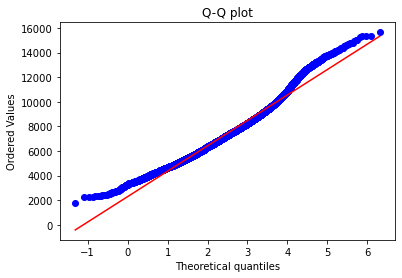

In [11]:
# Похоже на нормальное распределение, но доверяем критерию Шапиро-Уилка
fig = plt.figure()
ax = fig.add_subplot(111)
res = scipy.stats.probplot(data_2_day.metric, dist='norm', sparams=(2.5,), plot=ax)
ax.set_title("Q-Q plot")

Распределение ненормальное

Выбираем непараметрические критерии проверки гипотез


In [12]:
data = data.set_index('user_id')

Разделение данных на период обучения и на период теста

In [13]:
df_avg_all_train, df_avg_all_valid, df_avg_all_sample = time_split(data, 20, 10)
# сплит до 10 дня и после

In [14]:
df_all_group_train_reg = df_avg_all_train[['metric']].groupby(['user_id']).mean()
df_all_group_valid_reg = df_avg_all_valid[['metric']].groupby(['user_id']).mean()

In [15]:
regs = sorted(data.index.unique().tolist())

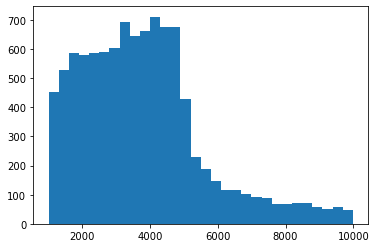

In [16]:
plt.hist(df_avg_all_train['metric'].tolist(), bins = 30);

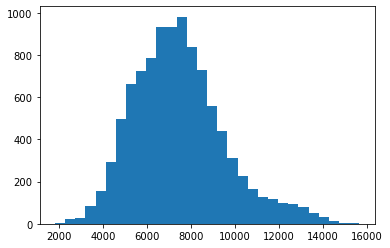

In [17]:
plt.hist(df_avg_all_valid['metric'].tolist(), bins = 30);

### Отбор похожих групп по критериям однородности.Используем критерий Манна-Уитни, Колмогорова-Смирнова и простую эвристику. Оцениваем эффективность по критерию Манна-Уитни.

In [18]:
%%time
iters = 1000
col_est = 'metric'
p_value = []
similar_groups = []
for i in range(iters):
    regs_A, regs_B = random_regs()
    df_all_A_train, df_all_B_train, df_all_A_valid, df_all_B_valid = search_df(regs_A, regs_B, False)
    p_k2s = scipy.stats.ks_2samp(df_all_A_train[col_est].tolist(),df_all_B_train[col_est].tolist()).pvalue
    p_mw = scipy.stats.mannwhitneyu(df_all_A_train[col_est].tolist(),df_all_B_train[col_est].tolist(), alternative='two-sided').pvalue
    mean = abs(df_all_B_train[col_est].mean() - df_all_A_train[col_est].mean())
    if p_mw > 0.05 and p_k2s > 0.05: #and mean < 1000:
        similar_groups.append([regs_A, regs_B])
        p_ans = scipy.stats.mannwhitneyu(df_all_A_valid[col_est].tolist(), df_all_B_valid[col_est].tolist()).pvalue
        p_value.append(p_ans)

Wall time: 13 s


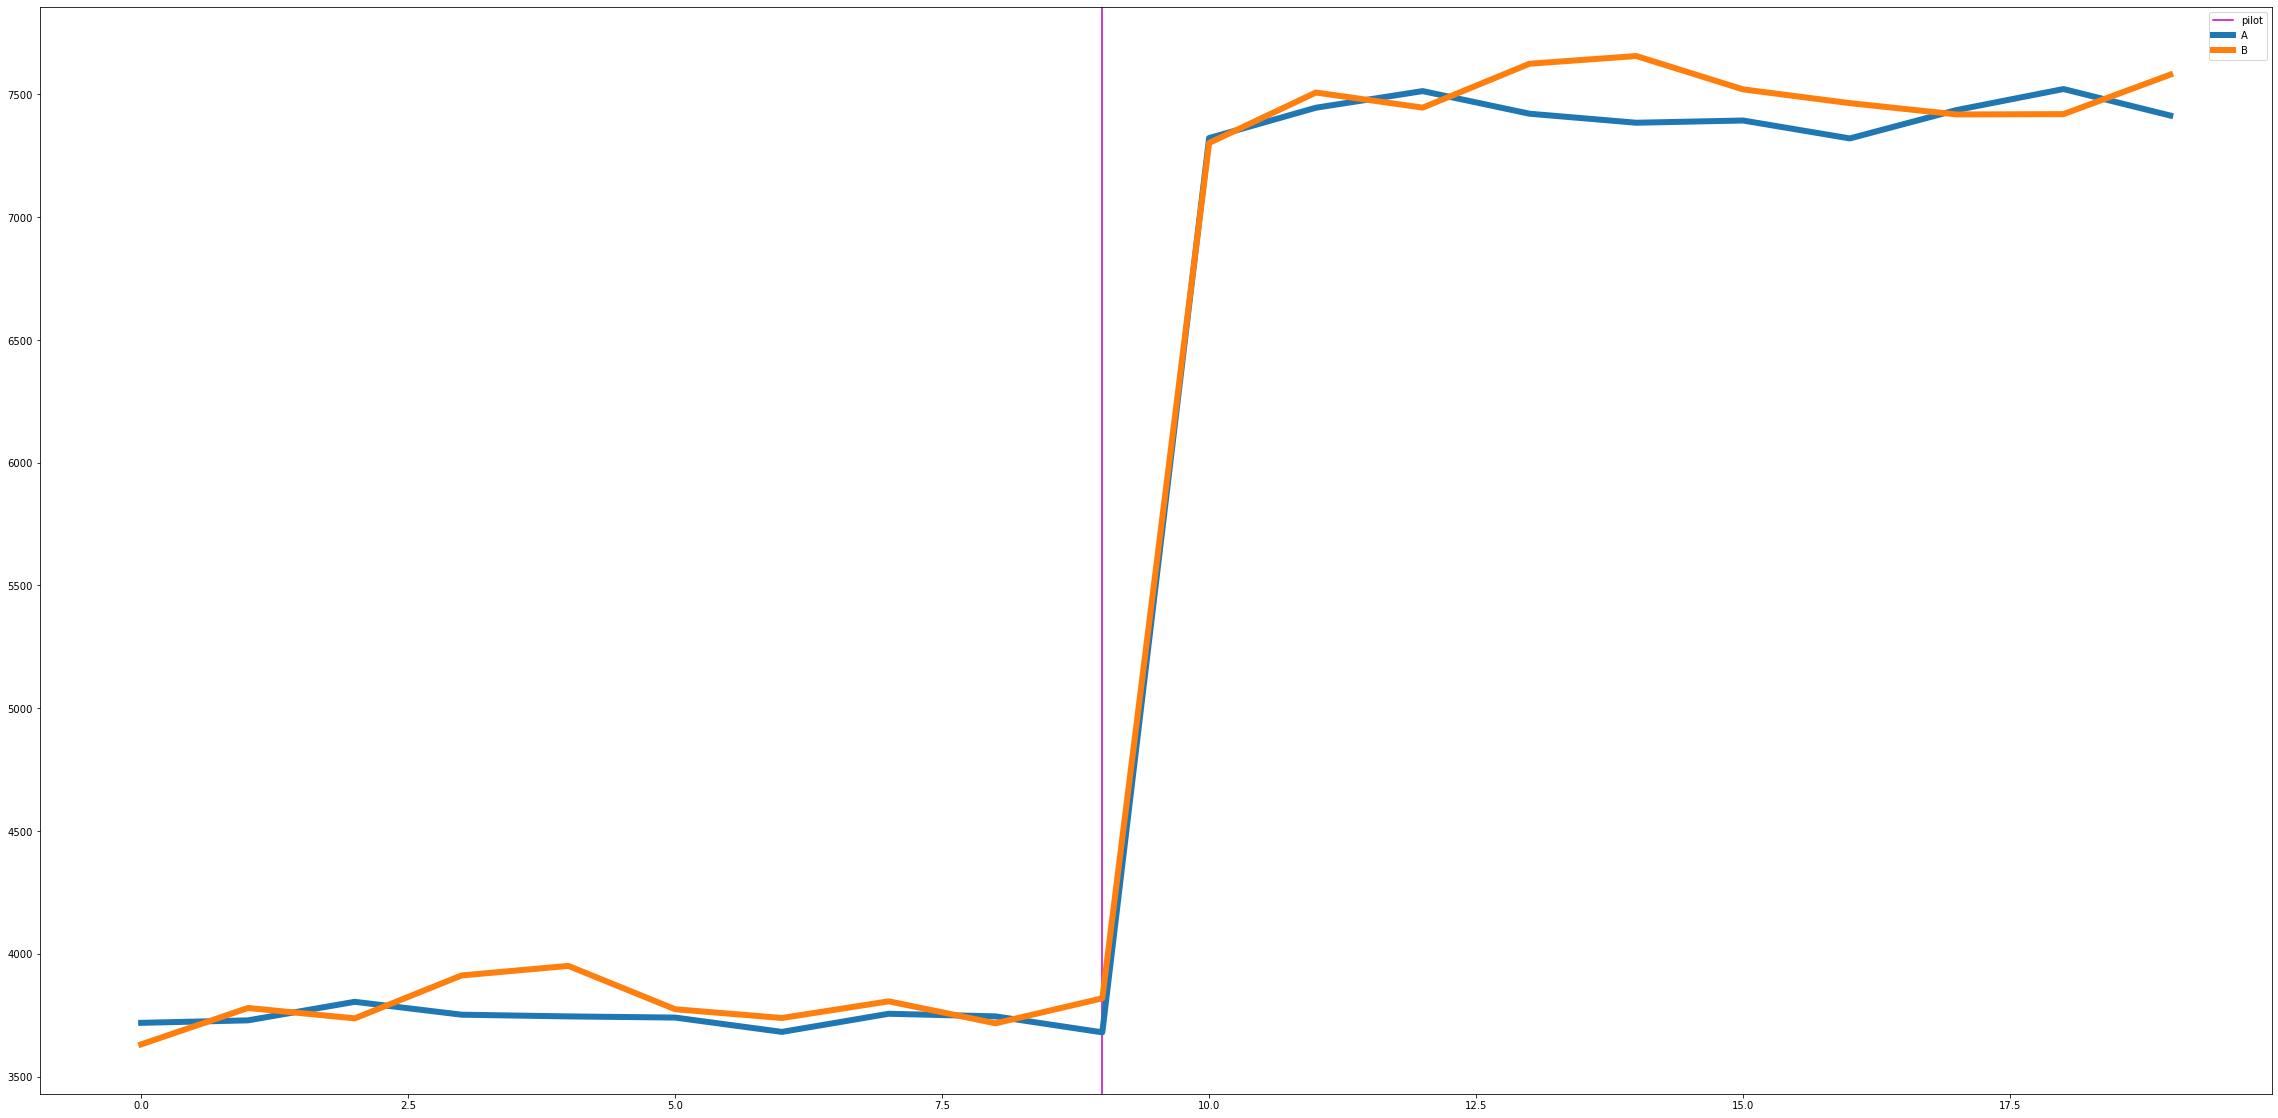

In [19]:
group = similar_groups[np.random.randint(len(similar_groups))]
regs_A, regs_B = group[0], group[1]
plot_tms('metric', 'day', regs_A, regs_B, 'group_t')
plt.savefig('3.png')

На валидных данных группы продолжили быть одинаковыми, в соответсвии с критерием Манна-Уитни.
Критерий корректен

число похожих групп: 909
0.0781078107810781


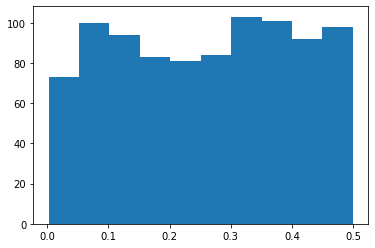

In [20]:
print(f'число похожих групп: {len(similar_groups)}')
p_values_array = np.array(p_value)
print(p_values_array[p_values_array < 0.05].shape[0] / p_values_array.shape[0])
plt.hist(p_value)
plt.savefig('4.png');

# Процент пар с pvalue < уровня значимости меньше показателя уровня значимости. 

Измерим мощность критерия, добавим эффект в одну валидную группу в размере 2%

In [21]:
%%time
iters = 1000
col_est = 'metric'
p_value = []
similar_groups = []
for i in range(iters):
    regs_A, regs_B = random_regs()
    df_all_A_train, df_all_B_train, df_all_A_valid, df_all_B_valid = search_df(regs_A, regs_B, False)
    p_k2s = scipy.stats.ks_2samp(df_all_A_train[col_est].tolist(),df_all_B_train[col_est].tolist()).pvalue
    p_mw = scipy.stats.mannwhitneyu(df_all_A_train[col_est].tolist(),df_all_B_train[col_est].tolist(), alternative='two-sided').pvalue
    mean = abs(df_all_B_train[col_est].mean() - df_all_A_train[col_est].mean())
    if p_mw > 0.05 and p_k2s > 0.05: #and mean < 1000:
        similar_groups.append([regs_A, regs_B])
        df_all_B_valid[col_est] = df_all_B_valid[col_est] * 1.02
        p_ans = scipy.stats.mannwhitneyu(df_all_A_valid[col_est].tolist(), df_all_B_valid[col_est].tolist()).pvalue
        p_value.append(p_ans)

Wall time: 12 s


число похожих групп: 940
0.9797872340425532


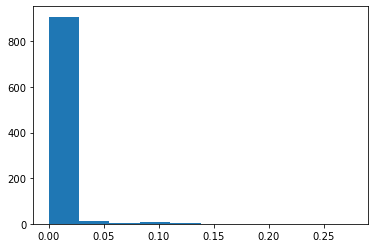

In [22]:
print(f'число похожих групп: {len(similar_groups)}')
p_values_array = np.array(p_value)
print(p_values_array[p_values_array < 0.05].shape[0] / p_values_array.shape[0])
plt.hist(p_value);

Мощность критерия, при изменении одной группы на 2% составляет 0.98

### Отбор похожих групп по критериям однородности.Используем критерий Манна-Уитни, Колмогорова-Смирнова и простую эвристику. Оцениваем эффективность по Перестановочному критерию.

In [25]:
%%time
iters = 1000
col_est = 'metric'
p_value = []
similar_groups = []
for i in range(iters):
    regs_A, regs_B = random_regs()
    df_all_A_train, df_all_B_train, df_all_A_valid, df_all_B_valid = search_df(regs_A, regs_B, False)
    p_k2s = scipy.stats.ks_2samp(df_all_A_train[col_est].tolist(),df_all_B_train[col_est].tolist()).pvalue
    p_mw = scipy.stats.mannwhitneyu(df_all_A_train[col_est].tolist(),df_all_B_train[col_est].tolist(), alternative='two-sided').pvalue
    if p_k2s > 0.05 and p_mw > 0.05:
        similar_groups.append([regs_A, regs_B])
        p_ans = combination_test(np.array(df_all_A_valid[col_est].tolist()), np.array(df_all_B_valid[col_est].tolist()), plot=False, iters=100)
        p_value.append(p_ans)

Wall time: 32.5 s


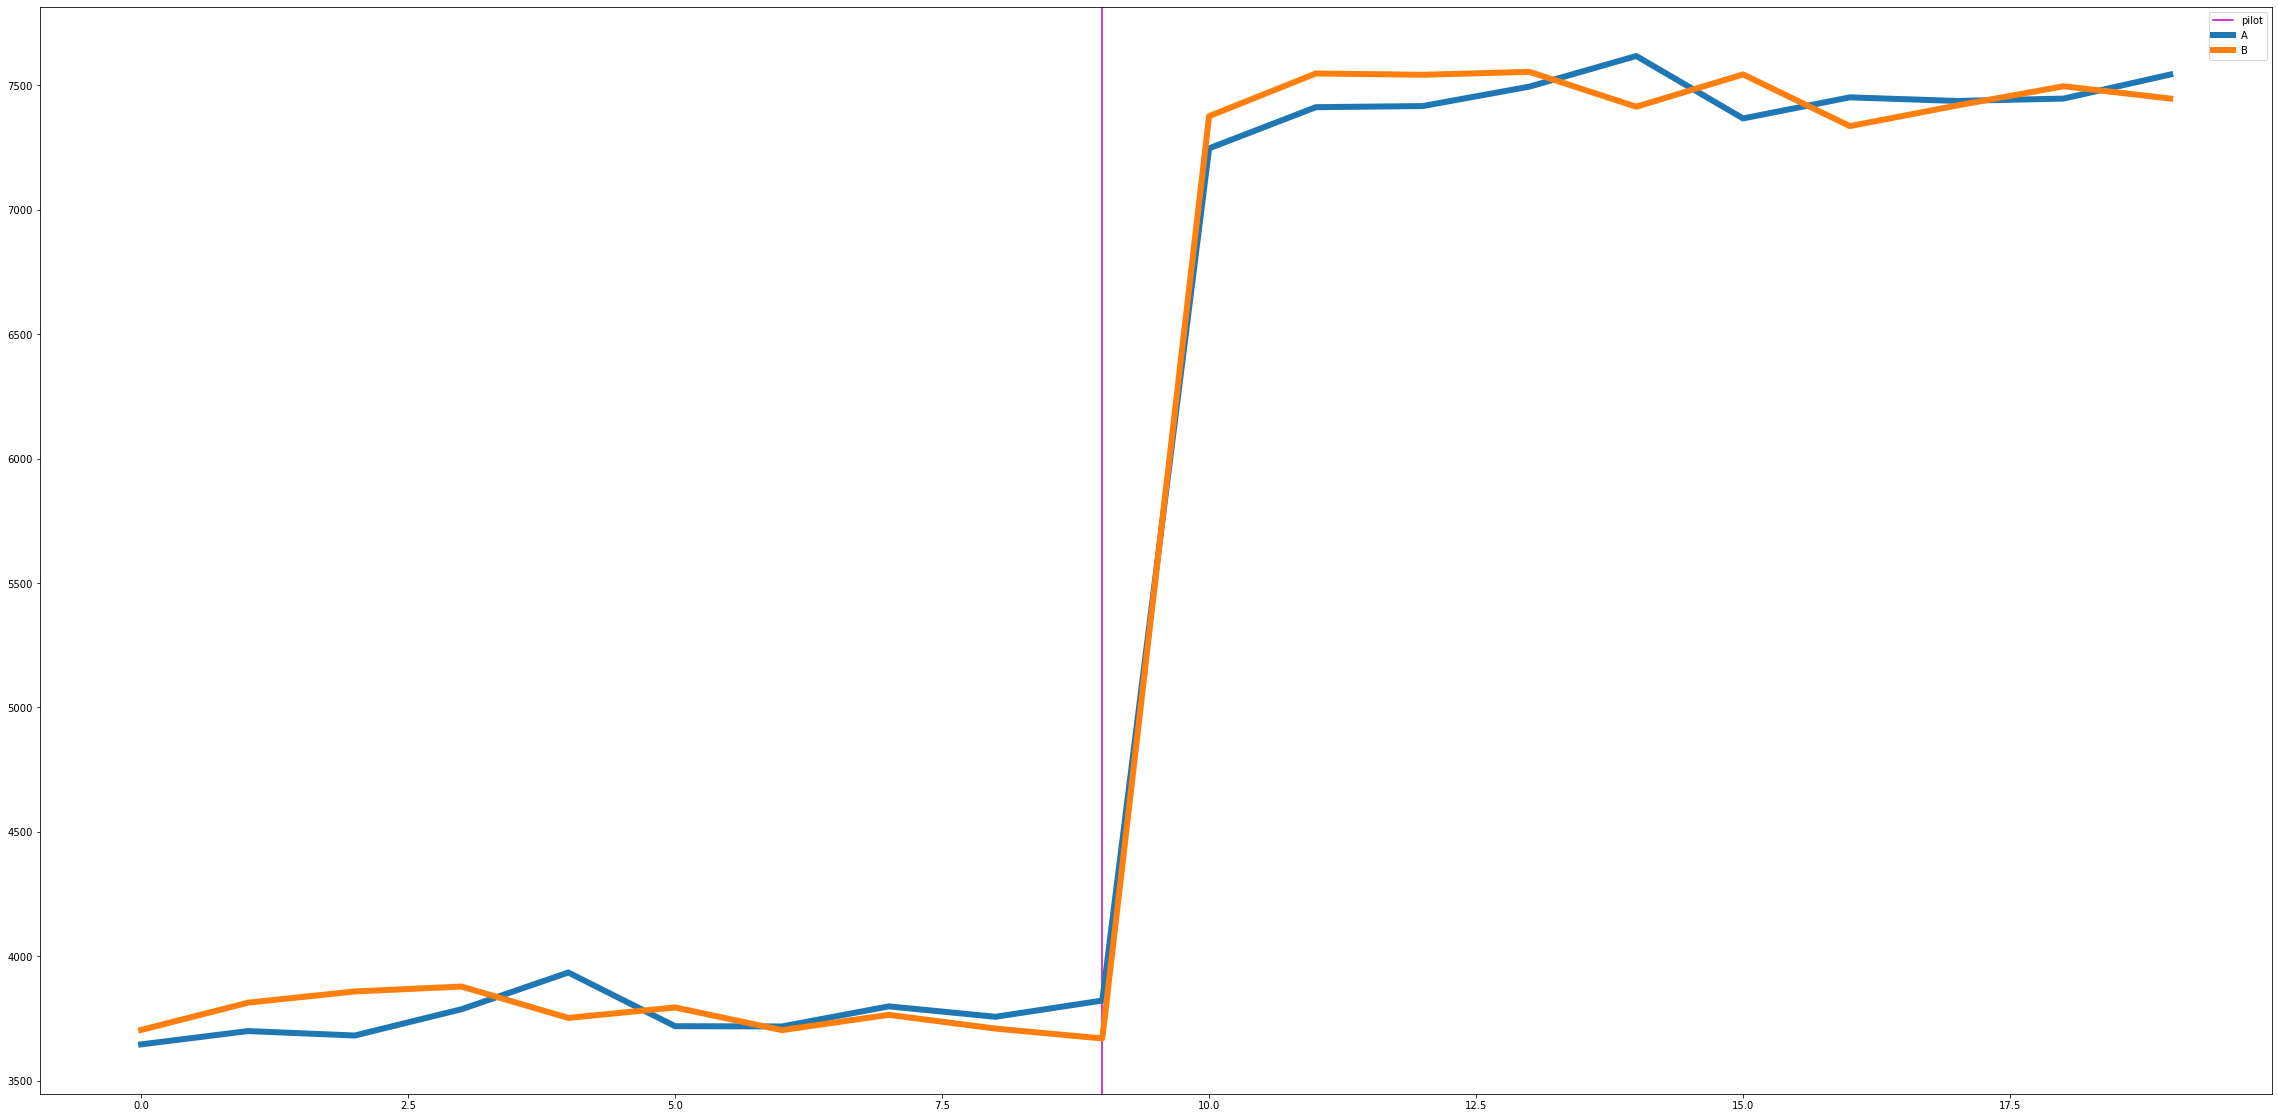

In [24]:
group = similar_groups[np.random.randint(len(similar_groups))]
regs_A, regs_B = group[0], group[1]
plot_tms('metric', 'day', regs_A, regs_B, 'group_t')

На валидных данных группы продолжили быть одинаковыми, в соответсвии с Перестановочным критерием. Критерий корректен

число похожих групп: 936
0.019230769230769232


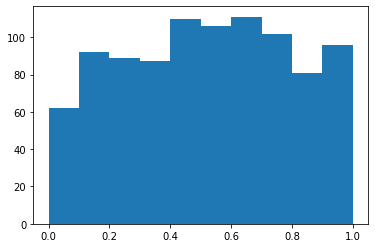

In [26]:
print(f'число похожих групп: {len(similar_groups)}')
p_value = np.array(p_value)
print(p_value[p_value < 0.05].shape[0] / len(similar_groups))
plt.hist(p_value)
plt.savefig('5.png');

Измерим мощность критерия, добавим эффект в одну валидную группу в размере 2%

In [26]:
%%time
iters = 1000
col_est = 'metric'
p_value = []
similar_groups = []
for i in range(iters):
    regs_A, regs_B = random_regs()
    df_all_A_train, df_all_B_train, df_all_A_valid, df_all_B_valid = search_df(regs_A, regs_B, False)
    p_k2s = scipy.stats.ks_2samp(df_all_A_train[col_est].tolist(),df_all_B_train[col_est].tolist()).pvalue
    p_mw = scipy.stats.mannwhitneyu(df_all_A_train[col_est].tolist(),df_all_B_train[col_est].tolist(), alternative='two-sided').pvalue
    if p_k2s > 0.05 and p_mw > 0.05:
        similar_groups.append([regs_A, regs_B])
        df_all_B_valid[col_est] = df_all_B_valid[col_est] * 1.02
        p_ans = combination_test(np.array(df_all_A_valid[col_est].tolist()), np.array(df_all_B_valid[col_est].tolist()), plot=False, iters=100)
        p_value.append(p_ans)

Wall time: 30.1 s


0.9535864978902954


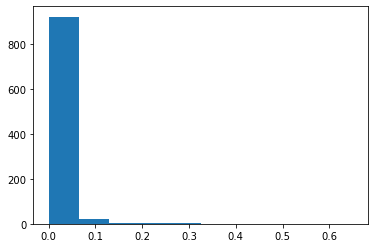

In [27]:
p_value = np.array(p_value)
print(p_value[p_value < 0.05].shape[0] / len(similar_groups))
plt.hist(p_value);

Мощность критерия, при изменении одной группы на 2% составляет 0.95

### Отбор похожих групп по критериям однородности.Используем критерий Манна-Уитни, Колмогорова-Смирнова и простую эвристику. Оцениваем эффективность по Бутстрепу.

In [27]:
%%time
iters = 1000
col_est = 'metric'
correct = []
pvalues = []
similar_groups = []
for i in range(iters):
    regs_A, regs_B = random_regs()
    df_all_A_train, df_all_B_train, df_all_A_valid, df_all_B_valid = search_df(regs_A, regs_B, False)
    p_k2s = scipy.stats.ks_2samp(df_all_A_train[col_est].tolist(),df_all_B_train[col_est].tolist()).pvalue
    p_mw = scipy.stats.mannwhitneyu(df_all_A_train[col_est].tolist(),df_all_B_train[col_est].tolist(), alternative='two-sided').pvalue
    if p_k2s > 0.05 and p_mw > 0.05:
        similar_groups.append([regs_A, regs_B])
        dist = bootstrap(np.array(df_all_A_valid[col_est].tolist()), np.array(df_all_B_valid[col_est].tolist()), return_distribution=True)
        left_side, right_side = get_boundary(dist)
        pvalues.append(get_p_value(dist))
        correct.append(not left_side <= 0 <= right_side)

Wall time: 33.8 s


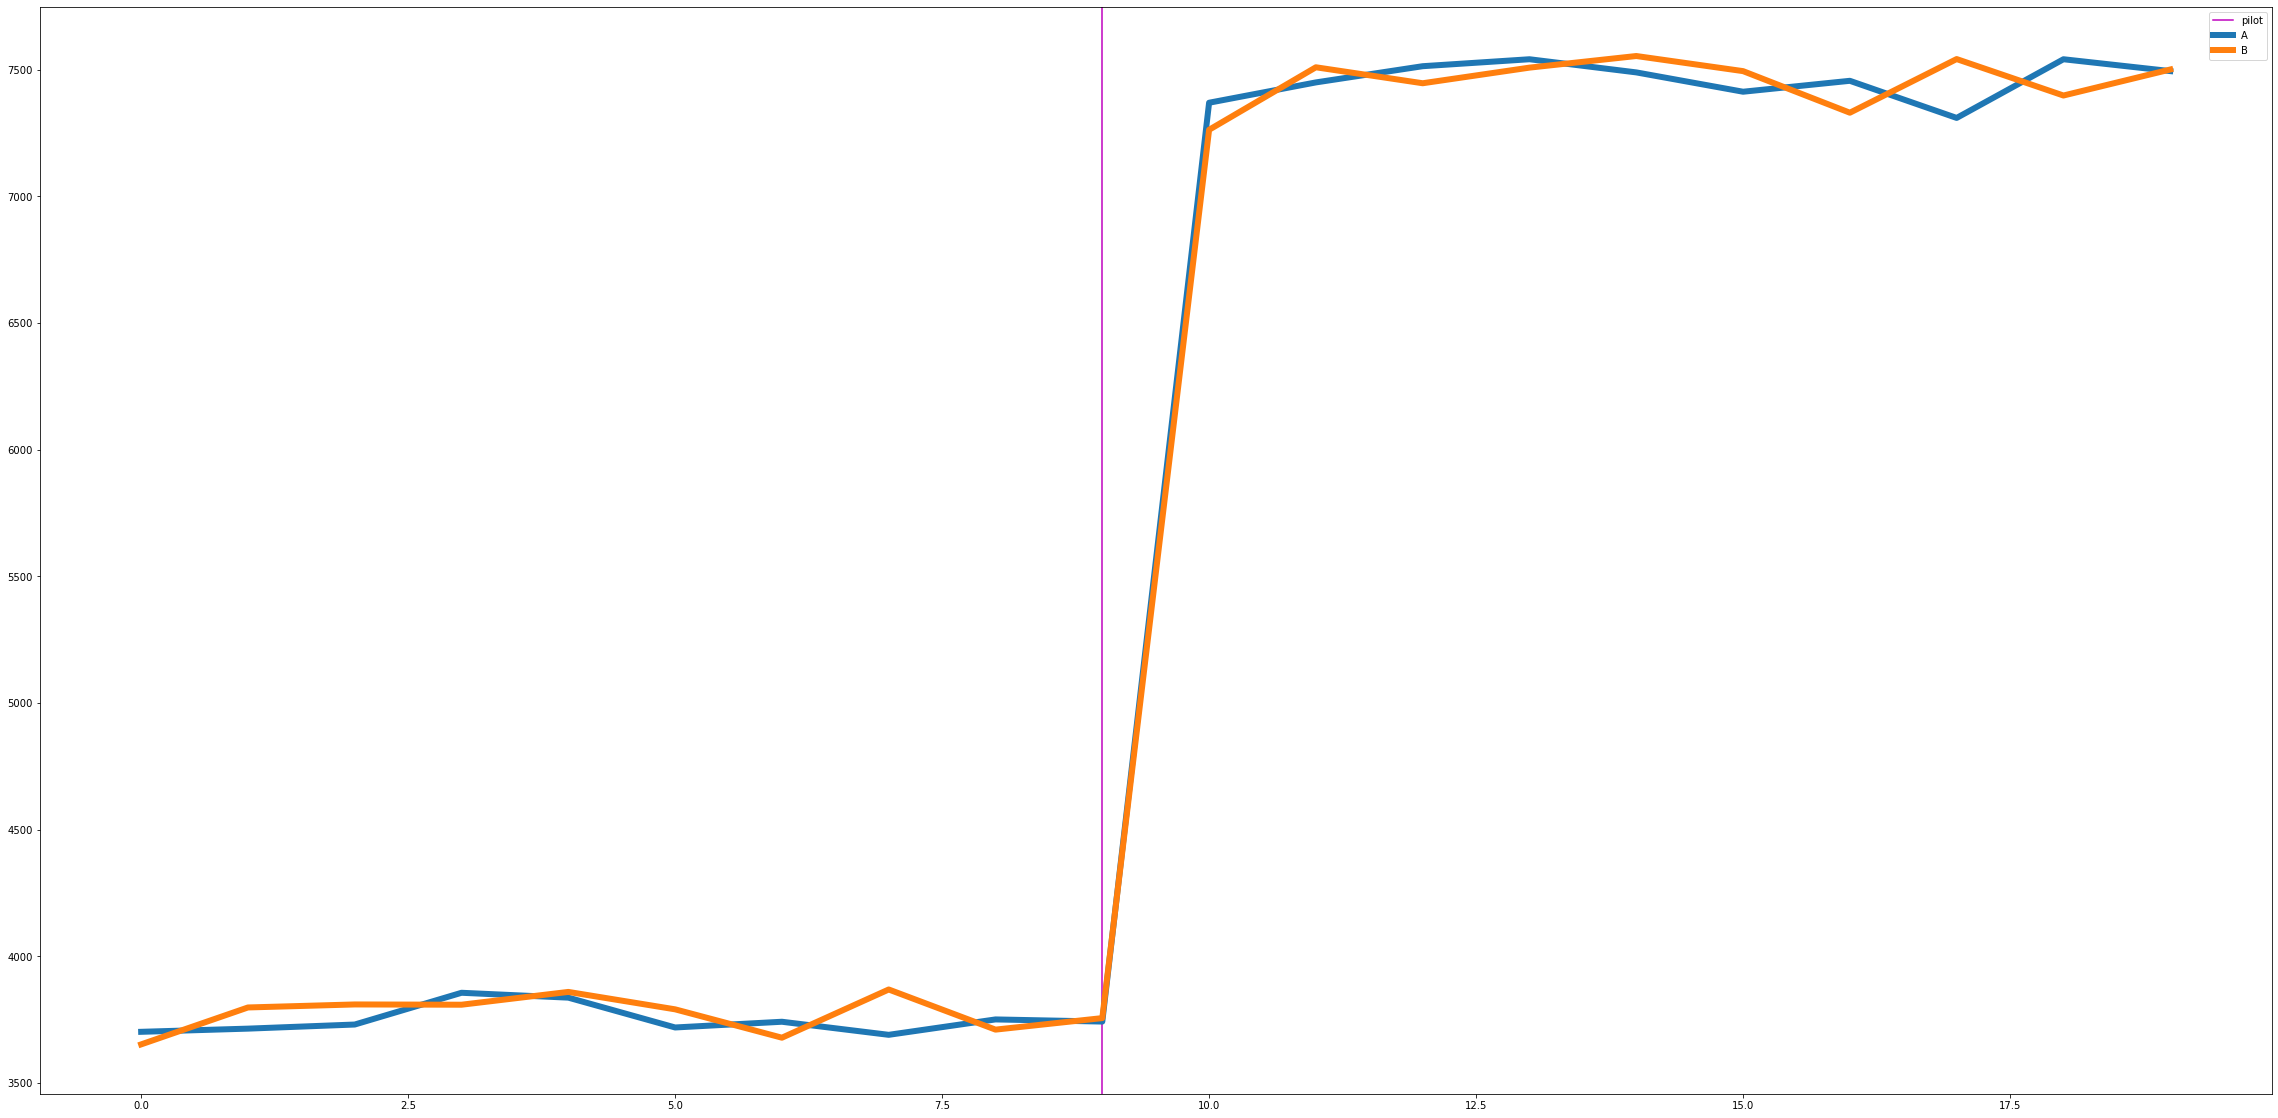

In [28]:
group = similar_groups[np.random.randint(len(similar_groups))]
regs_A, regs_B = group[0], group[1]
plot_tms('metric', 'day', regs_A, regs_B, 'group_t')

Критерий корректен

Выборки не отличаются, 0 входит в доверительный интервал

0.03358613217768147
[-84.71016925  78.30966467]


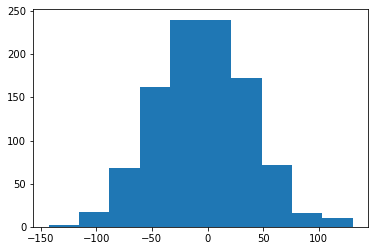

In [29]:
print(np.mean(correct))
plt.hist(bootstrap(np.array(df_all_A_valid[col_est].tolist()), np.array(df_all_B_valid[col_est].tolist()), iters=1000, return_distribution=True))
print(bootstrap(np.array(df_all_A_valid[col_est].tolist()), np.array(df_all_B_valid[col_est].tolist()), iters=1000))
plt.savefig('6.png');

Измерим мощность критерия, добавим эффект в одну валидную группу в размере 2%

In [31]:
%%time
iters = 1000
col_est = 'metric'
correct = []
pvalues = []
similar_groups = []
for i in range(iters):
    regs_A, regs_B = random_regs()
    df_all_A_train, df_all_B_train, df_all_A_valid, df_all_B_valid = search_df(regs_A, regs_B, False)
    p_k2s = scipy.stats.ks_2samp(df_all_A_train[col_est].tolist(),df_all_B_train[col_est].tolist()).pvalue
    p_mw = scipy.stats.mannwhitneyu(df_all_A_train[col_est].tolist(),df_all_B_train[col_est].tolist(), alternative='two-sided').pvalue
    if p_k2s > 0.05 and p_mw > 0.05:
        similar_groups.append([regs_A, regs_B])
        df_all_B_valid[col_est] = df_all_B_valid[col_est] * 1.02
        dist = bootstrap(np.array(df_all_A_valid[col_est].tolist()), np.array(df_all_B_valid[col_est].tolist()), return_distribution=True)
        left_side, right_side = get_boundary(dist)
        pvalues.append(get_p_value(dist))
        correct.append(not left_side <= 0 <= right_side)

Wall time: 35.3 s


0.9667738478027867
[-243.87075018  -81.43588466]


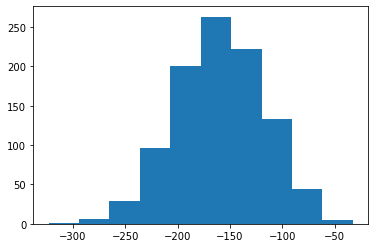

In [32]:
print(np.mean(correct))
plt.hist(bootstrap(np.array(df_all_A_valid[col_est].tolist()), np.array(df_all_B_valid[col_est].tolist()), iters=1000, return_distribution=True))
print(bootstrap(np.array(df_all_A_valid[col_est].tolist()), np.array(df_all_B_valid[col_est].tolist()), iters=1000))

Мощность критерия, при изменении одной группы на 2% составляет 0.95

### При изменении метрики одной из валидационных групп на 2% процента наилучший результат по мощности показал критерий Манна-Уитни (0.98)

### Можно ли статистически значимо задетектить эффект в 2%? Если можно, то за какую длительность теста?

### Определения продолжительности и размера выборки. Тест критерия на 6 днях


In [33]:
# data['group'] = np.where(data['day'] <=9, 'A', 'B')

In [34]:
df_avg_all_train, df_avg_all_valid, df_avg_all_sample = time_split(data, 20, 10)

In [35]:
%%time
iters = 1000
col_est = 'metric'
p_value = []
similar_groups = []
for i in range(iters):
    regs_A, regs_B = random_regs()
    df_all_A_train, df_all_B_train, df_all_A_valid, df_all_B_valid = search_df(regs_A, regs_B, False)
    df_all_A_train_n_days = df_all_A_train[df_all_A_train.day <= 5]
    df_all_B_train_n_days = df_all_B_train[df_all_B_train.day <= 5]
    df_all_A_valid_n_days = df_all_A_valid[df_all_A_valid.day <= 15]
    df_all_B_valid_n_days = df_all_B_valid[df_all_B_valid.day <= 15]
    p_k2s = scipy.stats.ks_2samp(df_all_A_train_n_days[col_est].tolist(),
                                 df_all_B_train_n_days[col_est].tolist()).pvalue
    p_mw = scipy.stats.mannwhitneyu(df_all_A_train_n_days[col_est].tolist(),
                                   df_all_B_train_n_days[col_est].tolist(), alternative='two-sided').pvalue
    mean = abs(df_all_B_train_n_days[col_est].mean() - df_all_A_train_n_days[col_est].mean())
    if p_k2s > 0.05 and p_mw > 0.05 #and mean < 1000:
        similar_groups.append([regs_A, regs_B])
        p_ans = scipy.stats.mannwhitneyu(df_all_A_valid_n_days[col_est].tolist(),
                                         df_all_B_valid_n_days[col_est].tolist()).pvalue
        p_value.append(p_ans)

Wall time: 36.7 s


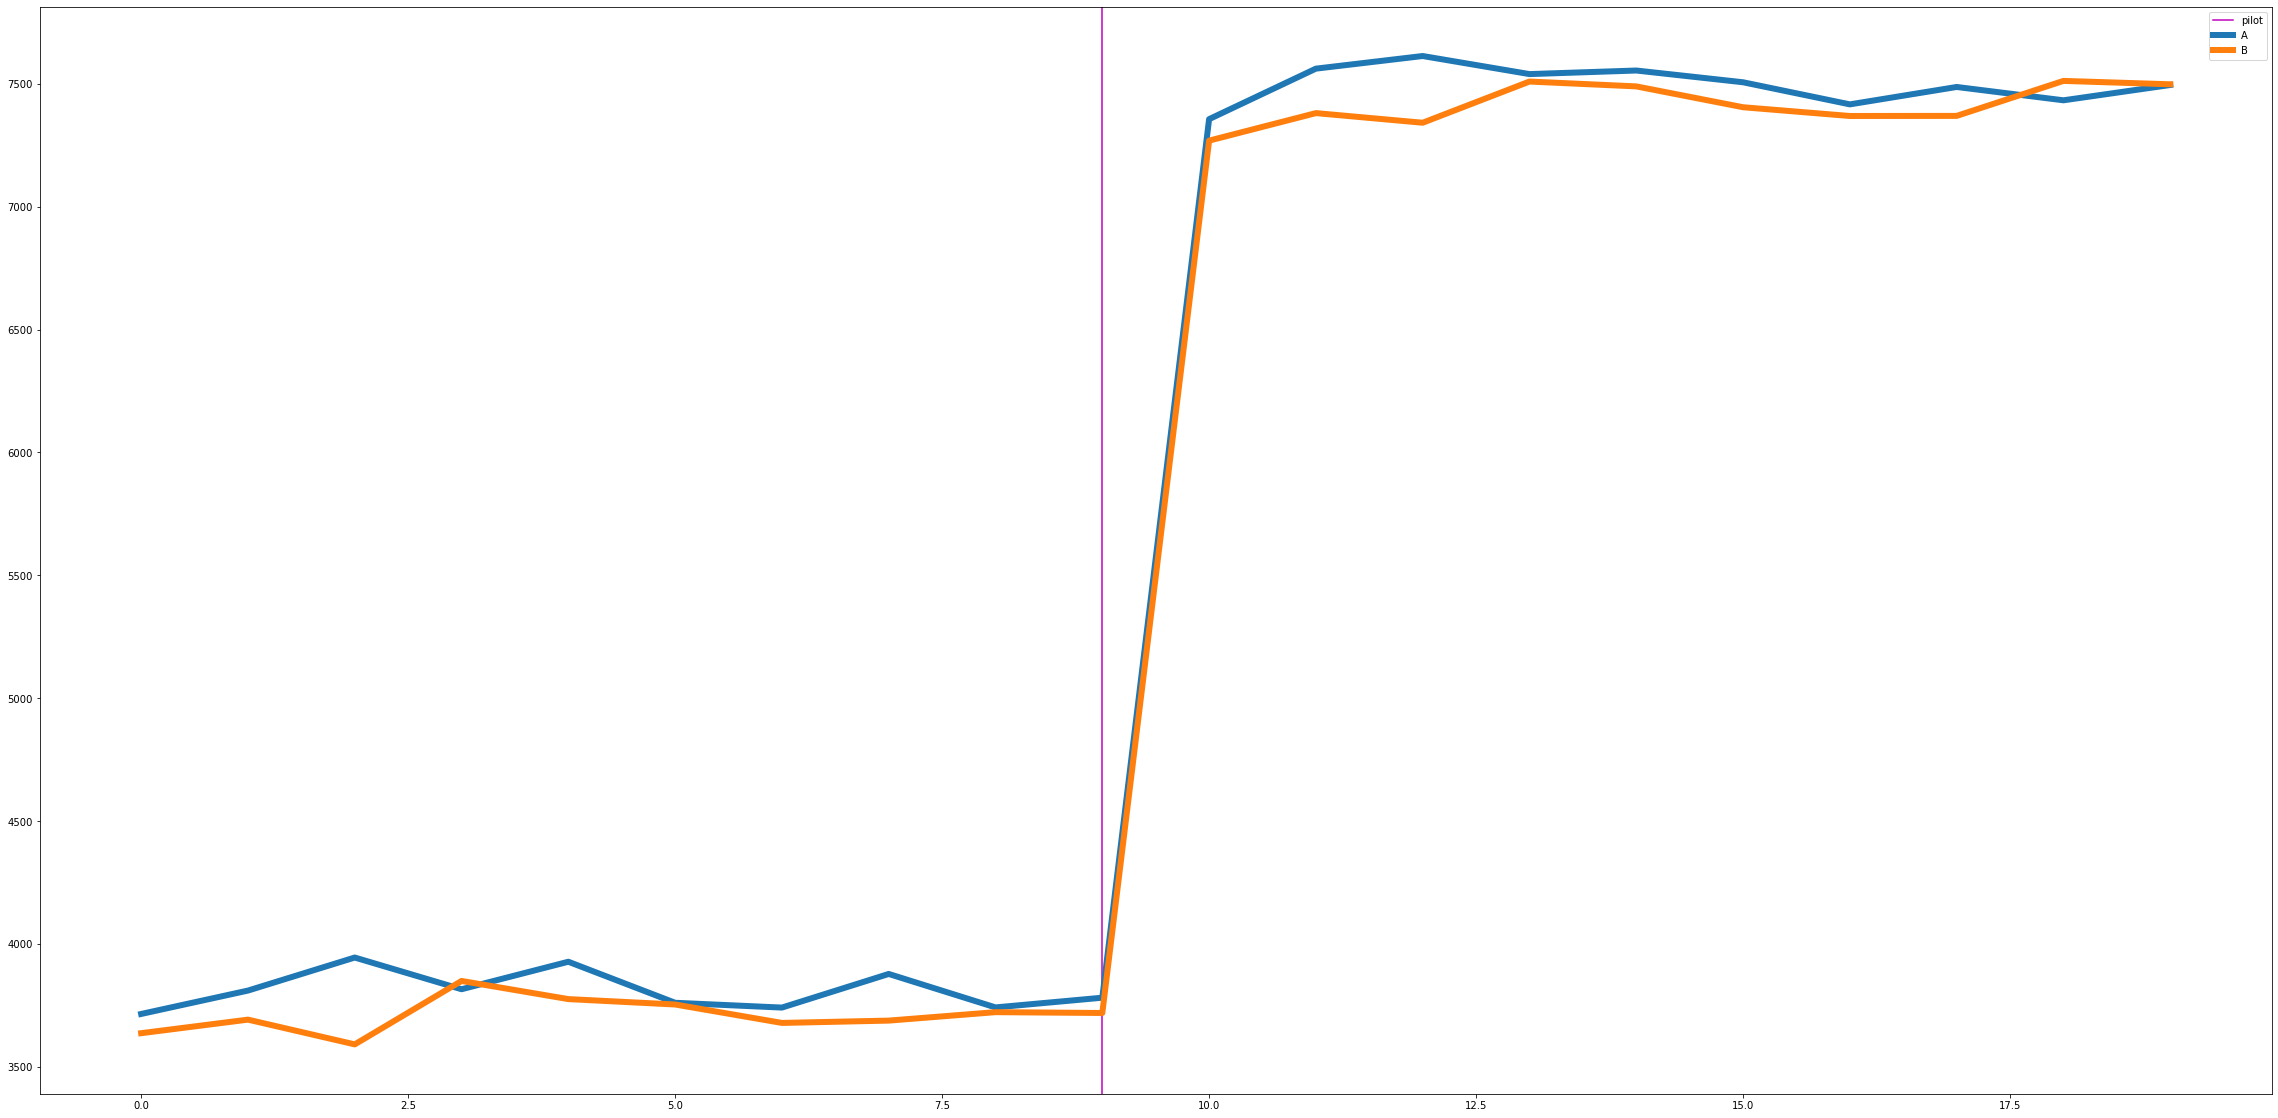

In [36]:
group = similar_groups[np.random.randint(len(similar_groups))]
regs_A, regs_B = group[0], group[1]
plot_tms('metric', 'day', regs_A, regs_B, 'group_t')

число похожих групп: 940
0.07872340425531915


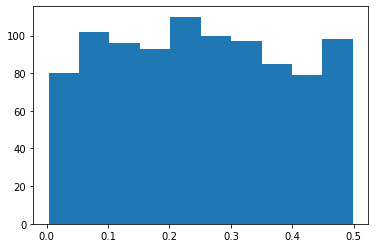

In [37]:
print(f'число похожих групп: {len(similar_groups)}')
p_values_array = np.array(p_value)
print(p_values_array[p_values_array < 0.05].shape[0] / p_values_array.shape[0])
plt.hist(p_value);

# Процент пар с pvalue < уровня значимости меньше показателя уровня значимости. Критерий корректен

In [38]:
# С эффектом 2%

iters = 1000
col_est = 'metric'
p_value = []
similar_groups = []
for i in range(iters):
    regs_A, regs_B = random_regs()
    df_all_A_train, df_all_B_train, df_all_A_valid, df_all_B_valid = search_df(regs_A, regs_B, False)
    df_all_A_train_n_days = df_all_A_train[df_all_A_train.day <= 5]
    df_all_B_train_n_days = df_all_B_train[df_all_B_train.day <= 5]
    df_all_A_valid_n_days = df_all_A_valid[df_all_A_valid.day <= 15]
    df_all_B_valid_n_days = df_all_B_valid[df_all_B_valid.day <= 15]
    p_k2s = scipy.stats.ks_2samp(df_all_A_train_n_days[col_est].tolist(),
                                 df_all_B_train_n_days[col_est].tolist()).pvalue
    p_mw = scipy.stats.mannwhitneyu(df_all_A_train_n_days[col_est].tolist(),
                                   df_all_B_train_n_days[col_est].tolist(), alternative='two-sided').pvalue
    mean = abs(df_all_B_train_n_days[col_est].mean() - df_all_A_train_n_days[col_est].mean())
    if p_k2s > 0.05 and p_mw > 0.05 #and mean < 1000:
        similar_groups.append([regs_A, regs_B])
        df_all_B_valid_n_days[col_est] = df_all_B_valid_n_days[col_est] * 1.02
        p_ans = scipy.stats.mannwhitneyu(df_all_A_valid_n_days[col_est].tolist(),
                                         df_all_B_valid_n_days[col_est].tolist()).pvalue
        p_value.append(p_ans)

число похожих групп: 915
0.8688524590163934


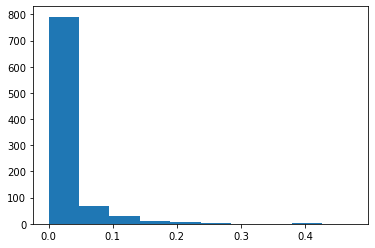

In [39]:
print(f'число похожих групп: {len(similar_groups)}')
p_values_array = np.array(p_value)
print(p_values_array[p_values_array < 0.05].shape[0] / p_values_array.shape[0])
plt.hist(p_value);

# Мощность критерия > 0.80 !

### Тест критерия на 5 днях

In [40]:
# С эффектом 2%

iters = 1000
col_est = 'metric'
p_value = []
similar_groups = []
for i in range(iters):
    regs_A, regs_B = random_regs()
    df_all_A_train, df_all_B_train, df_all_A_valid, df_all_B_valid = search_df(regs_A, regs_B, False)
    df_all_A_train_n_days = df_all_A_train[df_all_A_train.day <= 4]
    df_all_B_train_n_days = df_all_B_train[df_all_B_train.day <= 4]
    df_all_A_valid_n_days = df_all_A_valid[df_all_A_valid.day <= 14]
    df_all_B_valid_n_days = df_all_B_valid[df_all_B_valid.day <= 14]
    p_k2s = scipy.stats.ks_2samp(df_all_A_train_n_days[col_est].tolist(),
                                 df_all_B_train_n_days[col_est].tolist()).pvalue
    p_mw = scipy.stats.mannwhitneyu(df_all_A_train_n_days[col_est].tolist(),
                                   df_all_B_train_n_days[col_est].tolist(), alternative='two-sided').pvalue
    mean = abs(df_all_B_train_n_days[col_est].mean() - df_all_A_train_n_days[col_est].mean())
    if p_k2s > 0.05 and p_mw > 0.05 and mean < 1000:
        similar_groups.append([regs_A, regs_B])
        df_all_B_valid_n_days[col_est] = df_all_B_valid_n_days[col_est] * 1.02
        p_ans = scipy.stats.mannwhitneyu(df_all_A_valid_n_days[col_est].tolist(),
                                         df_all_B_valid_n_days[col_est].tolist()).pvalue
        p_value.append(p_ans)

5000
0.7974413646055437


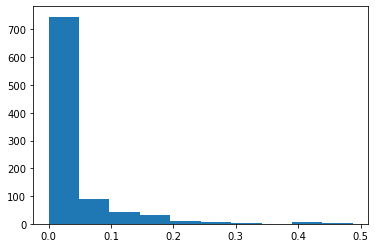

In [41]:
print(len(df_all_A_valid_n_days[col_est].tolist()) + len(df_all_B_valid_n_days[col_est].tolist()))

p_values_array = np.array(p_value)
print(p_values_array[p_values_array < 0.05].shape[0] / p_values_array.shape[0])
plt.hist(p_value);

# Мощность критерия > 0.80 !

### Выводы: 

#### После отбора похожих групп по критериям однородности с использованием критерия Манна-Уитни, Колмогорова-Смирнова и эвристики, при оценки эффективности по критерию Манна-Уитни при проведении а/б тестирования metric эффект в размере 2% может быть обнаружен за 5 дней тестирования с участием 5000 человек(А = 2500, Б = 2500)

### Как сделать так, чтобы на проведение А/Б теста с детектированием эффекта в 2% хватало 3-х дней?
### Воспользуемся средствами повышения чувствительности критерия

In [44]:
# С эффектом 2%
# 5 дней
iters = 1000
col_est = 'metric'
p_value = []
similar_groups = []
for i in range(iters):
    regs_A, regs_B = random_regs()
    df_all_A_train, df_all_B_train, df_all_A_valid, df_all_B_valid = search_df(regs_A, regs_B, False)
    df_all_A_train_n_days = df_all_A_train[df_all_A_train.day <= 4]
    df_all_B_train_n_days = df_all_B_train[df_all_B_train.day <= 4]
    df_all_A_valid_n_days = df_all_A_valid[df_all_A_valid.day <= 14]
    df_all_B_valid_n_days = df_all_B_valid[df_all_B_valid.day <= 14]
    p_k2s = scipy.stats.ks_2samp(df_all_A_train_n_days[col_est].tolist(),
                                 df_all_B_train_n_days[col_est].tolist()).pvalue
    p_mw = scipy.stats.mannwhitneyu(df_all_A_train_n_days[col_est].tolist(),
                                   df_all_B_train_n_days[col_est].tolist(), alternative='two-sided').pvalue
    mean = abs(df_all_B_train_n_days[col_est].mean() - df_all_A_train_n_days[col_est].mean())
    if p_k2s > 0.05 and p_mw > 0.05 and mean < 1000:
        similar_groups.append([regs_A, regs_B])
        df_all_B_valid_n_days[col_est] = df_all_B_valid_n_days[col_est] * 1.02
        df_all_A, df_all_B = cuped(df_all_A_train, df_all_B_train, df_all_A_valid, df_all_B_valid_n_days)
        df_all_A_ = df_all_A.sort_values('cuped').reset_index().reset_index()
        df_all_B_ = df_all_B.sort_values('cuped').reset_index().reset_index()
        p_ans = scipy.stats.mannwhitneyu(df_all_A['cuped'].tolist(), df_all_B['cuped'].tolist(), alternative='two-sided').pvalue
        p_value.append(p_ans)

1.0


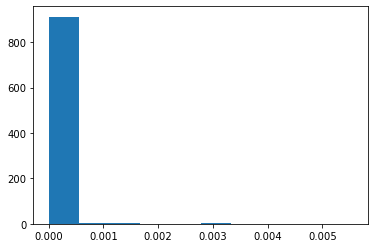

In [45]:
p_values_array = np.array(p_value)
print(p_values_array[p_values_array < 0.05].shape[0] / p_values_array.shape[0])
plt.hist(p_value);

In [50]:
# С эффектом 2%
# 3 дня
iters = 1000
col_est = 'metric'
p_value = []
similar_groups = []
for i in range(iters):
    regs_A, regs_B = random_regs()
    df_all_A_train, df_all_B_train, df_all_A_valid, df_all_B_valid = search_df(regs_A, regs_B, False)
    df_all_A_train_n_days = df_all_A_train[df_all_A_train.day <= 2]
    df_all_B_train_n_days = df_all_B_train[df_all_B_train.day <= 2]
    df_all_A_valid_n_days = df_all_A_valid[df_all_A_valid.day <= 12]
    df_all_B_valid_n_days = df_all_B_valid[df_all_B_valid.day <= 12]
    p_k2s = scipy.stats.ks_2samp(df_all_A_train_n_days[col_est].tolist(),
                                 df_all_B_train_n_days[col_est].tolist()).pvalue
    p_mw = scipy.stats.mannwhitneyu(df_all_A_train_n_days[col_est].tolist(),
                                   df_all_B_train_n_days[col_est].tolist(), alternative='two-sided').pvalue
    mean = abs(df_all_B_train_n_days[col_est].mean() - df_all_A_train_n_days[col_est].mean())
    if p_k2s > 0.05 and p_mw > 0.05 and mean < 1000:
        similar_groups.append([regs_A, regs_B])
        df_all_B_valid_n_days[col_est] = df_all_B_valid_n_days[col_est] * 1.02
        df_all_A, df_all_B = cuped(df_all_A_train, df_all_B_train, df_all_A_valid, df_all_B_valid_n_days)
        df_all_A_ = df_all_A.sort_values('cuped').reset_index().reset_index()
        df_all_B_ = df_all_B.sort_values('cuped').reset_index().reset_index()
        p_ans = scipy.stats.mannwhitneyu(df_all_A['cuped'].tolist(), df_all_B['cuped'].tolist(), alternative='two-sided').pvalue
        p_value.append(p_ans)

1.0


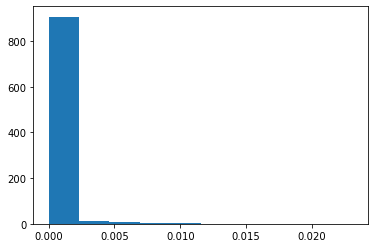

In [51]:
p_values_array = np.array(p_value)
print(p_values_array[p_values_array < 0.05].shape[0] / p_values_array.shape[0])
plt.hist(p_value);

In [52]:
# С эффектом 2%
# 2 дня
iters = 1000
col_est = 'metric'
p_value = []
similar_groups = []
for i in range(iters):
    regs_A, regs_B = random_regs()
    df_all_A_train, df_all_B_train, df_all_A_valid, df_all_B_valid = search_df(regs_A, regs_B, False)
    df_all_A_train_n_days = df_all_A_train[df_all_A_train.day <= 1]
    df_all_B_train_n_days = df_all_B_train[df_all_B_train.day <= 1]
    df_all_A_valid_n_days = df_all_A_valid[df_all_A_valid.day <= 11]
    df_all_B_valid_n_days = df_all_B_valid[df_all_B_valid.day <= 11]
    p_k2s = scipy.stats.ks_2samp(df_all_A_train_n_days[col_est].tolist(),
                                 df_all_B_train_n_days[col_est].tolist()).pvalue
    p_mw = scipy.stats.mannwhitneyu(df_all_A_train_n_days[col_est].tolist(),
                                   df_all_B_train_n_days[col_est].tolist(), alternative='two-sided').pvalue
    mean = abs(df_all_B_train_n_days[col_est].mean() - df_all_A_train_n_days[col_est].mean())
    if p_k2s > 0.05 and p_mw > 0.05 and mean < 1000:
        similar_groups.append([regs_A, regs_B])
        df_all_B_valid_n_days[col_est] = df_all_B_valid_n_days[col_est] * 1.02
        df_all_A, df_all_B = cuped(df_all_A_train, df_all_B_train, df_all_A_valid, df_all_B_valid_n_days)
        df_all_A_ = df_all_A.sort_values('cuped').reset_index().reset_index()
        df_all_B_ = df_all_B.sort_values('cuped').reset_index().reset_index()
        p_ans = scipy.stats.mannwhitneyu(df_all_A['cuped'].tolist(), df_all_B['cuped'].tolist(), alternative='two-sided').pvalue
        p_value.append(p_ans)

0.9754535752401281


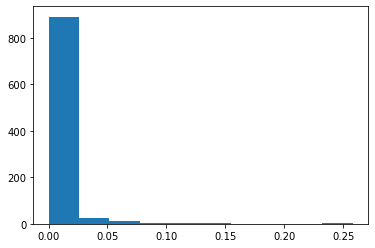

In [53]:
p_values_array = np.array(p_value)
print(p_values_array[p_values_array < 0.05].shape[0] / p_values_array.shape[0])
plt.hist(p_value);

### Выводы: 

#### Добиться мощности критерия Манна-Уитни > 0.80 при наличии эффекта в 2% на наших данных возможно. 

#### Наши данные можно агрегировать по юзерам за определенный период времени. Благодаря CUPED смогли увеличить мощность критерия до 97 при данных за 2 дня. Если бы мощность была не большая, то можно было добавить ранговое преобразование.